In [22]:
import pandas as pd
import nltk
import re
import spacy

# Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import cross_val_score
import logging
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
import os
import joblib



In [23]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info("Reading dataset.csv")

df = pd.read_csv('BIG_DATASET.csv',delimiter=';')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_lg")

2024-07-08 11:48:49,173 - INFO - Reading dataset.csv


In [24]:


def clean_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\W+', ' ', text)  
    text = re.sub(r'\s+', ' ', text) 
    return text

def lemmatize_tokens(tokens, model):
    doc = model(" ".join(tokens))
    return [token.lemma_ for token in doc]




In [25]:
if not os.path.exists('../preprocessed_text.csv'):
    stop_words = set(stopwords.words('english'))
    logging.info("Cleaning and preprocessing text")
    df['text'] = df['text'].apply(clean_text)

    logging.info("tokenizing")
    df['tokens'] = df['text'].apply(word_tokenize)

    logging.info("Removing StopWords")
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
    
    logging.info("lemantizing")
    df['tokens'] = df['tokens'].apply(lambda x: lemmatize_tokens(x, nlp))
    df = df.dropna(subset=['tokens'])
    logging.info("token-lambda")
    df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))
    df.to_csv('preprocessed_text.csv', index=False)
    logging.info("Preprocessed text saved to preprocessed_text.csv")
else:
    logging.info("Preprocessed text already exists, skipping preprocessing step")
    df = pd.read_csv('../preprocessed_text.csv')
    df = df.dropna(subset=['tokens'])

2024-07-08 11:48:50,760 - INFO - Preprocessed text already exists, skipping preprocessing step


In [26]:
def plot_confusion_matrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    correct_sum = sum(conf_mat[i][i] for i in range(conf_mat.shape[0]))
    incorrect_sum = sum(sum(row) for row in conf_mat) - correct_sum

    print(f"Correct predictions: {correct_sum}")
    print(f"Incorrect predictions: {incorrect_sum}")
    plt.figure(figsize=(20, 10)) 
    plt.imshow(conf_mat, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    labels = ['Junior', 'Pleno', 'Senior']
    plt.xticks(range(conf_mat.shape[1]), labels)
    plt.yticks(range(conf_mat.shape[0]), labels)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            plt.text(j, i, str(conf_mat[i, j]), ha="center", va="center", color="red")

    plt.show() 




def plot_confusion_matrixXG(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    correct_sum = sum(conf_mat[i][i] for i in range(conf_mat.shape[0]))
    incorrect_sum = sum(sum(row) for row in conf_mat) - correct_sum

    print(f"Correct predictions: {correct_sum}")
    print(f"Incorrect predictions: {incorrect_sum}")
    plt.figure(figsize=(20, 10)) 
    plt.imshow(conf_mat, interpolation='nearest', cmap='Greens')
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    labels = ['Junior', 'Pleno', 'Senior']
    plt.xticks(range(conf_mat.shape[1]), labels)
    plt.yticks(range(conf_mat.shape[0]), labels)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            plt.text(j, i, str(conf_mat[i, j]), ha="center", va="center", color="red")

    plt.show() 




In [27]:
df['tokens']= df['tokens'].dropna()

Model precision:0.72
Model recall:0.73
Model F1-score:0.71
Correct predictions: 261
Incorrect predictions: 98


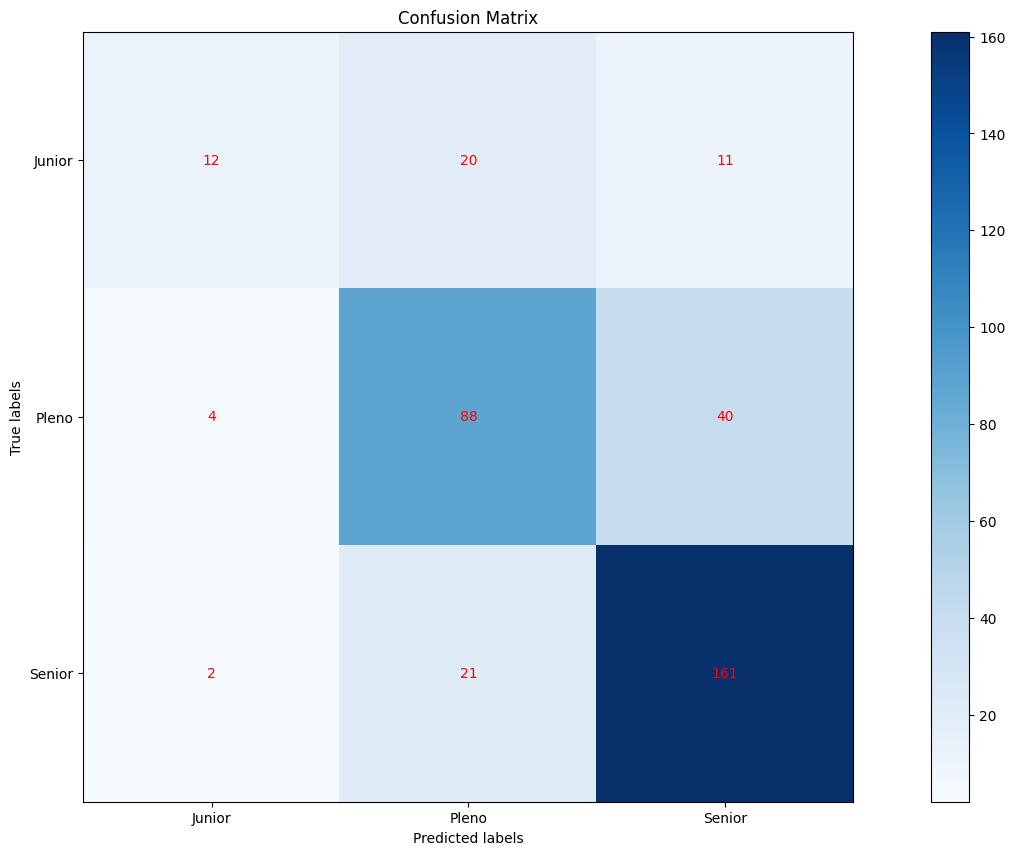

Model Accuracy: 0.7270194986072424


In [28]:


def train_model(df):
  
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['tokens'])
    X_training, X_test, y_training, y_test = train_test_split(X, df['seniority_number'], test_size=0.1, stratify=df['seniority_number'], random_state=42)
    model = LogisticRegression()
    model.fit(X_training, y_training)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model precision:{precision:.2f}")
    print(f"Model recall:{recall:.2f}")
    print(f"Model F1-score:{f1:.2f}")
    plot_confusion_matrix(y_test, y_pred)
    return model, vectorizer, accuracy


model, vectorizer, accuracy = train_model(df)


print("Model Accuracy:", accuracy)


In [29]:
def train_model2(df):
    
    vectorizer = TfidfVectorizer()

    X = vectorizer.fit_transform(df['tokens'])
    y = df['seniority_number']  
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, cv=5)  
    return model, scores.mean()


model, Accuracy = train_model2(df)

print("model accuracy:", Accuracy)

model accuracy: 0.6920763111350053


Model precision:0.72
Model recall:0.72
Model F1-score:0.72
Correct predictions: 643
Incorrect predictions: 253


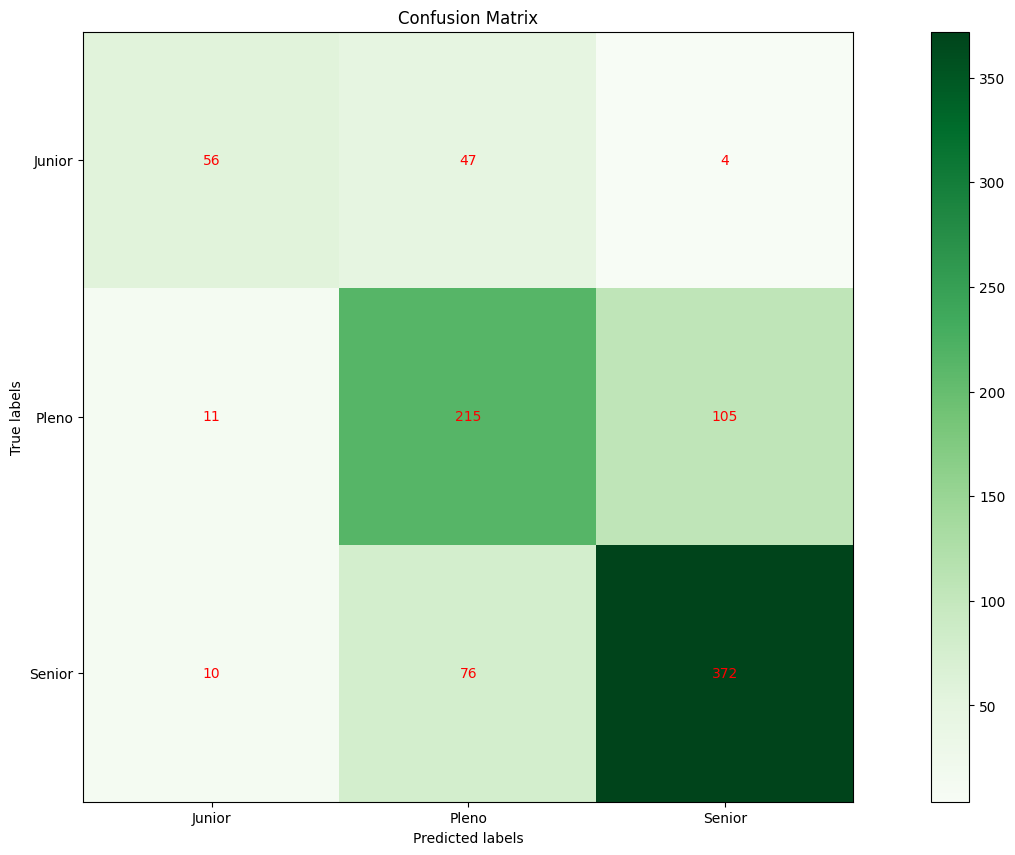

model accuracy: 0.7176339285714286


In [30]:
def train(df):

    X_train, X_test, y_train, y_test = train_test_split(df['tokens'], df['seniority_number'],stratify=df['seniority_number'], test_size=0.25, random_state=None)
    vectorizer1 = CountVectorizer()
    X_train_vec = vectorizer1.fit_transform(X_train)
    X_test_vec = vectorizer1.transform(X_test)
    model1 = xgb.XGBClassifier()
    model1.fit(X_train_vec, y_train)
    y_pred = model1.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model precision:{precision:.2f}")
    print(f"Model recall:{recall:.2f}")
    print(f"Model F1-score:{f1:.2f}")
    plot_confusion_matrixXG(y_test, y_pred)
    return model1, vectorizer1, accuracy


model1,vectorizer1,accuracy_model3=train(df)
print("model accuracy:", accuracy_model3)

In [31]:
# joblib.dump(model1, 'model_seniority-xg76-sp.pkl')
# joblib.dump(vectorizer1, 'vectorizer_seniority-xg76-sp.pkl')

Correct predictions: 275
Incorrect predictions: 84


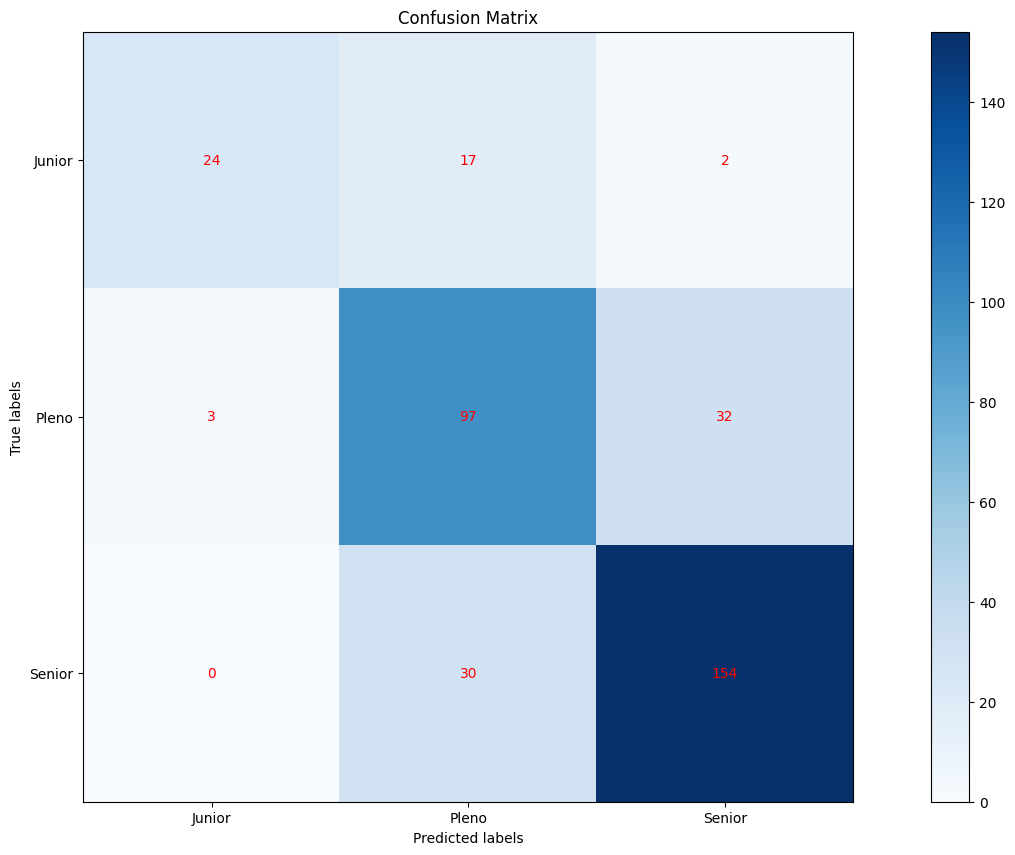

model accuracy: 0.766016713091922


In [32]:
def train(df):
    X_train, X_test, y_train, y_test = train_test_split(df['tokens'], df['seniority_number'], test_size=0.1, stratify=df['seniority_number'],random_state=None)
    vectorizer2 = CountVectorizer()
    X_train_vec = vectorizer2.fit_transform(X_train)
    X_test_vec = vectorizer2.transform(X_test)
    model2 = xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=1000, gamma=0, subsample=0.8,  colsample_bytree=0.8, reg_alpha=0, reg_lambda=1)
    model2.fit(X_train_vec, y_train)
    y_pred = model2.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred)
    return model2, vectorizer2, accuracy


model2,vectorizer2,accuracy_model3=train(df)
print("model accuracy:", accuracy_model3)

In [ ]:

from sklearn.ensemble import RandomForestClassifier


def train(df):
    X_train, X_test, y_train, y_test = train_test_split(df[['tokens']], df['seniority_number'],stratify=df['seniority_number'], test_size=0.1, random_state=None)

  
    vectorizer4 = TfidfVectorizer()
    X_train_vec = vectorizer4.fit_transform(X_train)
    X_test_vec = vectorizer4.transform(X_test)

   
    modelRandom = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=10, min_samples_split=2)
    modelRandom.fit(X_train_vec, y_train)

    y_pred = modelRandom.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model precision:{precision:.2f}")
    print(f"Model recall:{recall:.2f}")
    print(f"Model F1-score:{f1:.2f}")
    plot_confusion_matrix(y_test, y_pred)
    return modelRandom, vectorizer4, accuracy

modelRandom, vectorizer4, accuracy_model3 = train(df)
print("model accuracy:", accuracy_model3)